# Data Preparation


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [26]:
#data set from kaggle: https://www.kaggle.com/competitions/grupo-bimbo-inventory-demand/data

# Define the chunk size
chunk_size = 4000000  # Adjust the chunk size based on your memory capacity
chunks = pd.read_csv('grupo-bimbo-inventory-demand/train.csv/train.csv', chunksize=chunk_size)

# Now you can work with the 'train' DataFrame
train = next(chunks)

# rename columns
train = train.rename(columns={'Semana': 'Week_num',
                                  'Agencia_ID': 'Sales_Depot_ID',
                                  'Canal_ID': 'Sales_Channel_ID',
                                  'Ruta_SAK': 'Route_ID',
                                  'Cliente_ID': 'Client_ID',
                                  'Venta_uni_hoy': 'Sales_unit_this_week',
                                  'Venta_hoy': 'Sales_this_week',
                                  'Dev_uni_proxima': 'Returns_unit_next_week',
                                  'Dev_proxima': 'Returns_next_week',
                                  'Demanda_uni_equil': 'Adjusted_demand',
                                  'Producto_ID': 'Product_ID'})

# calculate price
train['Price'] = train['Sales_this_week']/train['Sales_unit_this_week']
train['log_Price'] = np.log(train['Price'])

# read town/state data and merge with train
town_state = pd.read_csv('grupo-bimbo-inventory-demand/town_state.csv.zip', compression="zip")
town_state = town_state.rename(columns={'Agencia_ID': 'Sales_Depot_ID',
                                      'Town': 'Town',
                                      'State': 'State'})
train = train.merge(town_state, on='Sales_Depot_ID', how='left', copy=False)
del town_state

week_dummies = pd.get_dummies(train['Week_num'], prefix='week')
state_dummies = pd.get_dummies(train['State'], prefix='state')
train = pd.concat([train, week_dummies], axis=1)
train = pd.concat([train, state_dummies], axis=1)
del week_dummies, state_dummies

# dependent variable
train['log_adjusted_demand'] = np.log(train['Adjusted_demand'] + 1)

## Linear Regression
Let's write dowm the first regressions.
* Adjusted Demand on Price
* log(Adjusted Demand + 1) on log(Price)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

In [15]:
lr = LinearRegression()
X = train[['Price']]
X = X.fillna(0)
y = train['Adjusted_demand']
lr.fit(X, y)

preds = lr.predict(X)
print("Coefficient", lr.coef_ )
print("Intercept:", lr.intercept_)

Coefficient [-0.14416323]
Intercept: 8.294688034553308


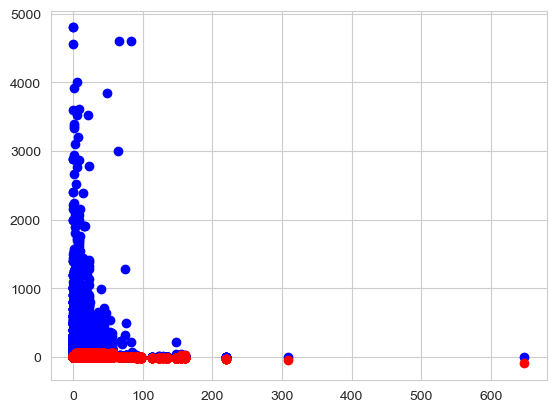

In [34]:
plt.scatter(x = train[['Price']], y = train['Adjusted_demand'], c = 'blue')
plt.scatter(x = train[['Price']], y = preds, c = 'red')

plt.show()

In [31]:
X = train[['log_Price']]
X = X.fillna(0)
y = train['log_adjusted_demand']
lr.fit(X,y)

preds = lr.predict(X)
print("Coefficient", lr.coef_ )
print("Intercept:", lr.intercept_)

Coefficient [-0.38653245]
Intercept: 2.4442972441058717


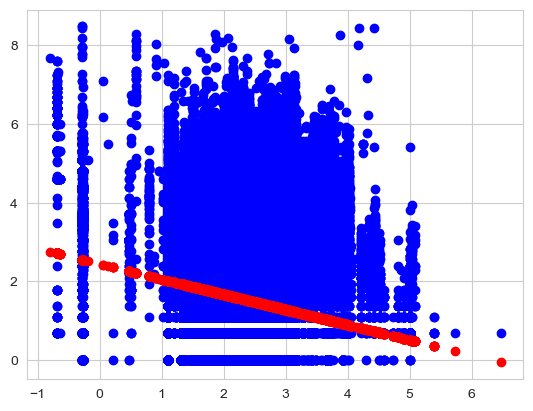

In [ ]:
plt.scatter(x = train[['log_Price']], y = train['log_adjusted_demand'], c = 'blue')
plt.scatter(x = train[['log_Price']], y = preds, c = 'red')

plt.show()

Let's write down the first regression which includes price, week FE, and state FE.

In [35]:
state_dummies = [col for col in train.columns if 'state_' in col]
week_dummies = [col for col in train.columns if 'week_' in col]
X = train[state_dummies + week_dummies + ['Price']]
X = X.fillna(0)
y = train['Adjusted_demand']
lr.fit(X, y)

preds = lr.predict(X)
lr.coef_

array([-2.62103086, -2.13254328, -2.77693987, -3.83499745, -4.14273686,
       -2.37306535, -4.30066955, -3.21935692, -1.00674958, -2.64411151,
       -4.93266354, -4.26405085, -2.19712383, -2.84132394, 50.78604382,
       -4.88400161, -2.61467882,  0.        , -0.15614487])

In [36]:
state_dummies = [col for col in train.columns if 'state_' in col]
week_dummies = [col for col in train.columns if 'week_' in col]
X = train[state_dummies + week_dummies + ['log_Price']]
X = X.fillna(0)
y = train['log_adjusted_demand']
lr.fit(X, y)

preds = lr.predict(X)
lr.coef_

array([-0.08309595, -0.01798431, -0.08727878, -0.10268654, -0.17650049,
       -0.05515509, -0.2121629 , -0.14716011,  0.08381649, -0.0412204 ,
       -0.27744089, -0.26945287, -0.11178283, -0.10024265,  1.98334961,
       -0.30909251, -0.07590978,  0.        , -0.39822935])

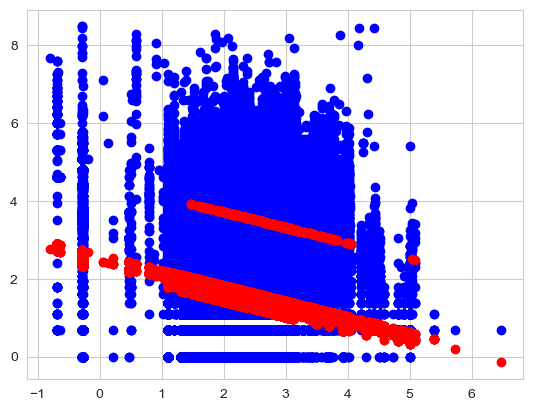

In [37]:
plt.scatter(x = train[['log_Price']], y = train['log_adjusted_demand'], c = 'blue')
plt.scatter(x = train[['log_Price']], y = preds, c = 'red')

plt.show()